In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [35]:
# 显示图像
def img_show(img):
    if len(img.shape) == 3:
        if img.shape[-1]==3:
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
        elif img.shape[-1]==4:
            b,g,r,a = cv2.split(img)
            img = img
        plt.imshow(img)
    elif len(img.shape) == 2:
        plt.imshow(img,cmap="gray")

In [36]:
# 随机加椒盐函数
def salt(img,n):
    # 循环添加n个椒盐
    for k in range(n):
        # 随机添加椒盐的坐标
        i = int(np.random.random()*img.shape[0])
        j = int(np.random.random()*img.shape[1])
        # 若位灰度图
        img[i,j] = 255
        # 若为RGB图
        img[i,j,0] = 255
        img[i,j,0] = 255
        img[i,j,0] = 255
    return img

In [37]:
# 清洗锐化图片
def cleaning(img):
    bgr = cv2.split(img)
    bgrNew = []
    for c in bgr:
        c = cv2.threshold(c,127,255,cv2.THRESH_BINARY)
        bgrNew.append(c[1])
    img = cv2.merge(bgrNew)
    return img

hand = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/hand.png")
cleaning(hand)
cv2.imwrite("/Users/tanjun/Desktop/tanjun/opencv/hand.png",hand)

True

# 17.1 用分水岭算法实现图像分割与提取

### 17.1.1 算法原理

In [38]:
# 任何一幅灰度图可以看成是地理学上的地形表面，灰度值高的区域看成山峰，低的区域看成山谷
# 向山谷中注水，虽水位上升，山谷会交汇，为放置不同山谷的交汇，我们需要在在交汇地方建堤坝
# 该过程将图像分成两部分：集水盆地和分水岭。我们建的堤坝就是分水岭，用于图像分割，这就是分水岭算法

### 17.1.2 相关函数介绍

In [63]:
# opencv中使用函数cv2.watershed()实现分水岭算法
# 具体实现过程中还要借助于形态学函数，距离变换函数cv2.distanceTransform()、cv2.connectedComponents()来完成图像分割

# 1.形态学函数回顾：
# 1）开运算：先腐蚀，后膨胀，去除图像噪声。
# 2）获取图像边界：通过形态学操作和减法运算能够获取图像边界

# 2.距离变换函数 distanceTransform
# 当图像内各个子图没有连接时，可以直接使用形态学的腐蚀操作确定前景对象，但如果图像内的子图连接在一起时，就很难确定前景对象了
# 此时要借助距离变换函数可方便地将前景对象提取出来
# 距离变换函数cv2.distanceTransform()计算二值图像内任意点到最近背景点的距离，即计算所有像素点到最近0值像素点的距离，本身为0，距离为0
# 如果前景对象的中心（质心）距离值为0的像素点较远，就得到一个较大值，反之得到一个较小值
# 如果对上述结果进行阈值化，就可得到图像内子图的中心、骨架等信息
# 距离变换函数cv2.distanceTransform()可以用于计算对象中心，还能细化轮廓，获取图像前景等
# dst = cv2.distanceTransform(src,distanceType[,maskSize[,dstType]])
# src：8位单通道二值图
# distanceType：距离类型：
# cv2.DIST_USER       用户自定义距离
# cv2.DIST_L1         distance=|x1-x2|+|y1-y2|
# cv2.DIST_L2         欧式距离
# cv2.DIST_C          distance=max(|x1-x2|,|y1-y2|)
# cv2.DIST_L12        L1-L2 metric:distance=2(sqrt(1+x*x/2)-1)
# cv2.DIST_FAIR       distance=c^2/2(|x|/c-log(1+|x|/c)),c=1.3998
# cv2.DIST_WELSCH     distance=c^2/2(1-exp(-(x/c)^2)),c=2.9846
# cv2.DIST_HUBER      distance=|x|<c?x^2/2:c(|x|-c/2),c=1.345
# maskSize：掩模尺寸，其值如下。需注意，当distanceTpye=cv2.DIST_L1或cv2.DIST_C时，maskSize强制为3（3，5及更大值没有区别）
# cv2.DIST_MASK_3     3
# cv2.DIST_MASK_5     5
# cv2.DIST_MASD_PRECISE
# dstType：目标图像类型，默认CV_32F
# dst：目标图像，可以是8位或32位浮点数，尺寸同src

# 3.确定未知区域
# 使用形态学的膨胀操作能将图像内的前景放大，当前景放大后，背景就会被压缩，得到的背景小于实际背景，为不包含前景的确定背景
# 图中有了确定前景F和确定背景B，剩下的就是未知区域UN
# 未知区域UN = 图像O - 确定背景B - 确定前景F
# 未知区域UN = (图像O - 确定背景B) - 确定前景F

# 4.函数connectedConponents
# 明确了确定前景后，就可以对确定前景图进行标注了，在opencv中使用cv2.connetedComponents()进行标注
# retval,labels = cv2.connectedComponents(image)
# image：8位单通道待标注图像
# retval：返回的标注的数量
# labels：标注的结果图像

# 5.函数cv2.watershed()
# 完成上述处理后，就可以使用分水岭算法对预处理结果图像进行分割了，opencv提供了函数cv2.watershed()实现分水岭算法：
# markers = cv2.watershed(image,markers)
# iamge：输入图像，必须是8位3通道图像：
# 在对图像使用cv2.watershed()函数处理之前，必须先用正数大致勾勒出图像中的期望分割区域，每个分割区域会被标注为1，2，3等。
# 对尚未确定的区域，需将它们标注为0，我们可以将标注区域理解为分水岭算法分割的种子区域
# markers：32通道标注结果，和image等大小。
# 在markers中，每个像素要么被置为初期的种子值，要么被置为-1表示边界。markers可以省略。

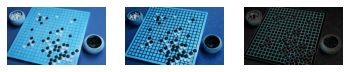

In [43]:
# 获取图像边界信息
wq = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/wq.jpeg", cv2.IMREAD_UNCHANGED)

k = np.ones((5,5),np.uint8)
e = cv2.erode(wq,k)
b = cv2.subtract(wq,e)

plt.subplot(131),plt.imshow(wq),plt.axis("off")
plt.subplot(132),plt.imshow(e),plt.axis("off")
plt.subplot(133),plt.imshow(b),plt.axis("off")
plt.show()

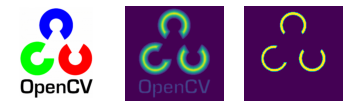

In [57]:
# 使用距离变换函数cv2.distanceTransform()计算一幅图像的前景
log = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/log.jpg")

# 用于显示的图像
log = cv2.cvtColor(wq,cv2.COLOR_BGR2RGB)
logShow = log.copy()

# 计算前景
gray = cv2.cvtColor(log,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret,fore = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# 显示
plt.subplot(131),plt.imshow(logShow),plt.axis("off")
plt.subplot(132),plt.imshow(dist_transform),plt.axis("off")
plt.subplot(133),plt.imshow(fore),plt.axis("off")
plt.show()

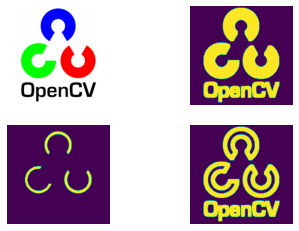

In [60]:
# 标注一幅图的确定前景，确定背景，未知区域
log = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/log.jpg")

# 用于显示的图像
log = cv2.cvtColor(wq,cv2.COLOR_BGR2RGB)
logShow = log.copy()

# 确定背景
gray = cv2.cvtColor(log,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)
bg = cv2.dilate(opening,kernel,iterations=3)

# 确定前景
dist = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret,fore = cv2.threshold(dist,0.7*dist.max(),255,0)
fore = np.uint8(fore)

# 未知区域
un = cv2.subtract(bg,fore)

# 显示
plt.subplot(221),plt.imshow(logShow),plt.axis("off")
plt.subplot(222),plt.imshow(bg),plt.axis("off")
plt.subplot(223),plt.imshow(fore),plt.axis("off")
plt.subplot(224),plt.imshow(un),plt.axis("off")
plt.show()

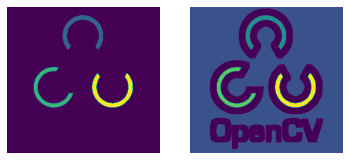

In [62]:
# 使用cv2.connectedComponents()标注一幅图像
log = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/log.jpg")

# 用于显示的图像
log = cv2.cvtColor(wq,cv2.COLOR_BGR2RGB)
logShow = log.copy()

# 确定背景
gray = cv2.cvtColor(log,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)
bg = cv2.dilate(opening,kernel,iterations=3)

# 确定前景
dist = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret,fore = cv2.threshold(dist,0.7*dist.max(),255,0)
fore = np.uint8(fore)

# 未知区域
un = cv2.subtract(bg,fore)

# 标注
ret,markers1 = cv2.connectedComponents(fore)
markers2 = markers1+1
markers2[un==255] = 0

# 显示
plt.subplot(121),plt.imshow(markers1),plt.axis("off")
plt.subplot(122),plt.imshow(markers2),plt.axis("off")
plt.show()

### 17.1.3 分水岭算法图像分割实例

In [64]:
# 基本步骤：
# 1.通过形态学开运算对图像去噪
# 2.通过腐蚀操作获取确定背景B。这里得到的“原始图像-确定背景”即可
# 3.利用距离变换函数cv2.distanceTransform()对原始图像进行运算，并对其进行阈值处理，得到确定前景F
# 4.计算未知区域UN(UN=O-B-F)
# 5.利用函数cv2.connectedComponents()对原始图像进行标注
# 6.对函数cv2.connectedComponents()的标注结果进行修正
# 7.使用分水岭函数cv2.watershed()完成图像分割

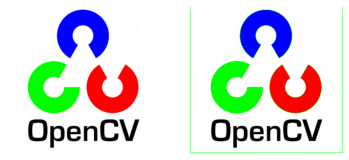

In [65]:
log = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/log.jpg")

log = cv2.cvtColor(wq,cv2.COLOR_BGR2RGB)
logShow = log.copy()

# 预处理
gray = cv2.cvtColor(log,cv2.COLOR_BGR2GRAY)
ret,thred = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# 1.通过形态学开运算对图像去噪
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thred,cv2.MORPH_OPEN,kernel,iterations=2)

# 2.通过腐蚀操作获取确定背景B。这里得到的“原始图像-确定背景”即可
bg = cv2.dilate(opening,kernel,iterations=3)

# 3.利用距离变换函数cv2.distanceTransform()对原始图像进行运算，并对其进行阈值处理，得到确定前景F
dist = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret,fg = cv2.threshold(dist,0.7*dist.max(),255,0)
fg = np.uint8(fg)

# 4.计算未知区域UN(UN=O-B-F)
un = cv2.subtract(bg,fg)

# 5.利用函数cv2.connectedComponents()对原始图像进行标注
ret,markers = cv2.connectedComponents(fg)

# 6.对函数cv2.connectedComponents()的标注结果进行修正
markers = markers + 1
markers[un==255] = 0

# 7.使用分水岭函数cv2.watershed()完成图像分割
markers = cv2.watershed(log,markers)
log[markers==-1] = [0,255,0]

# 显示
plt.subplot(121),plt.imshow(logShow),plt.axis("off")
plt.subplot(122),plt.imshow(log),plt.axis("off")
plt.show()

# 17.2 交互式前景提取

In [66]:
# 先用矩形框将要提取的前景框出来，再分别用白色和黑色对前景和背景进行标注，然后用交互式前景提取算法提取前景

# GradCut算法的具体实施过程：
# 1.将前景所在大致区域用矩形框标出。该区域以外被认为是确定背景
# 2.根据矩形框外部的确定背景数据来区分矩形框区域内的前景和背景
# 3.用高斯混合模型（GMM）对前景和背景建模。GMM会根据用户的输入学习并创建新的像素分布，对未分类的像素根据已知分类像素关系进行分类
# 4.根据像素分布情况生成一幅图，图中的节点就是各个像素。出像素点外，还有两个节点：前景节点和背景节点。
# 所有前景像素都和前景节点向连，所有背景像素都和背景节点相连。每个像素连接到前景节点和背景节点的权重由像素是前景或背景的概率决定
# 5.图中每个像素除了与前景节点或背景节点向连外，彼此之间还存在连接，两个像素连接边的权重值由它们的相似性决定，颜色越近权重值越大
# 6.完成节点连接后，需解决的问题变成了一幅联通的图。在该图上根据各自边的权重关系进行切割，将不同点划分为前景节点和背景节点
# 7.不断重复上述过程，知道分类收敛

# opencv提供函数cv2.grabCut()实现交互式前景提取：
# mask,bgdModel,fgdModel = cv2.grabCut(img,mask,rect,bgdModel,fgdModel,iterCount[,mode])
# img：输入图像，要求是8位3通道
# mask：掩模图像，8位单通道。该参数用于确定前景，背景和不确定区域，可设4中形式：
# cv2.GC_BGD     确定背景    0
# cv2.GC_FGD     确定前景    1
# cv2.GC_PR_BGD  可能的背景  2
# cv2.GC_PR_FGD  可能的前景  3
# 在最后使用模版提取前景时，会将参数0，2合并为背景（均当作0处理）；将参数1，3合并为前景（均当作1处理）
# 通常我们可使用白色笔刷和黑色笔刷在掩模上做标记，再通过转换将其中的白色像素设置为0，黑色像素设置为1
# ret：包含前景对象的区域，该区域外的部分被认为是确定背景。只有当参数mode设置为矩形模式cv2.GCINIT_WITH_RECT时参数rect才有意义
# 其个数为（x,y,w,h），如果前景位于右下方，又不想判断原始图像大小，对w和h设置一个很大的值就可以了。使用掩模模式，该值置为None即可
# bgdModel：算法内部使用的数组，只需要创建（1,65）大小的np.float64数组
# fgdModel：算法内部使用的数组，只需要创建（1,65）大小的np.float64数组
# iterCount：迭代次数
# mode：迭代模式：
# cv2.GC_INIT_WITH_RECT 矩形模版
# cv2.GC_INIT_WITH_MASK 自定义模版，注意cv2.GC_INIT_WITH_RECT和cv2.GC_INIT_WITH_MASK能组合使用，所有ROI区域外像素认定为背景
# cv2.GC_EVAL           修复模式
# cv2.GC_EVAL_FREEZE_MODEL  固定模式

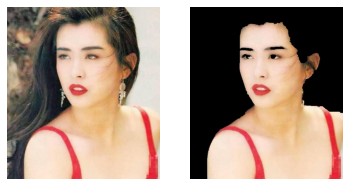

In [72]:
# 使用GrabCut算法提取前景
wzx = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/wzx.jpg")

wzxRGB = cv2.cvtColor(wzx,cv2.COLOR_BGR2RGB)

# 参数准备
mask = np.zeros(wzx.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,800,800)

# 交互式前景提取
cv2.grabCut(wzx,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask = np.where((mask==2)|(mask==0),0,1).astype("uint8")
wzxgc = wzx*mask[:,:,np.newaxis]
wzxgc = cv2.cvtColor(wzxgc,cv2.COLOR_BGR2RGB)

# 显示
plt.subplot(121),plt.imshow(wzxRGB),plt.axis("off")
plt.subplot(122),plt.imshow(wzxgc),plt.axis("off")
plt.show()

In [73]:
# 可以看到，在不实用掩模（掩模值都设置为默认值0时），cv2.grabcut()效果并不太好
# 为了得到完整前景对象，需做一些该进。
# 这里对原始图像进行标注，将需要保留的部分甚至为白色，将需要删除的背景设置为黑色，标记好的图像作为模版，提取前景

# 步骤：
# 1.利用函数cv2.grabcut()在cv2.GC_INIT_WITH_RECT模式下对图像进行初步的前景提取，得到初步提取结果og
# 2.使用windows操作系统自带的笔刷工具，打开要提取前景的图像
# 3.使用白色笔刷在希望提取的前景区域做标记
# 4.使用黑色笔刷在希望删除的背景区域做标记
# 5.将设置好的图像存为模版图像m0
# 6.将模版图像m0中的白色值和黑色值映射到模版m中。（255->1;0->0）
# 7.以模版m作为cv2.grabCut()的模版参数mask，对图像og完成前景提取

# 注意：参数mask的值必须是cv2.GC_BGD,cv2.GC_FGD,cv2.GC_PR_BGD,cv2.GC_PR_FGD,或则0，1，2，3之中的值

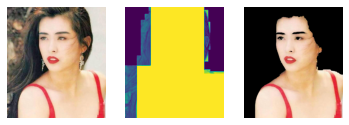

In [121]:
wzx = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/wzx.jpg")

wzxRGB = cv2.cvtColor(wzx,cv2.COLOR_BGR2RGB)

# 参数准备
mask = np.zeros(wzx.shape[:2],np.uint8)
bgd = np.zeros((1,65),np.float64)
fgd = np.zeros((1,65),np.float64)
rect = (50,50,800,800)

# 交互式前景提取
cv2.grabCut(wzx,mask,rect,bgd,fgd,5,cv2.GC_INIT_WITH_RECT)

mask2 = wzx[:,:,0].copy()
mask2[:300,:60] = 0
mask2[:250,60:80] = 0
mask2[:70,80:100] = 0
mask2[:40,100:120] = 0
mask2[:20,400:420] = 0
mask2[:80,420:430] = 0
mask2[:80,420:440] = 0
mask2[280:320,400:420] = 0
mask2[220:320,420:440] = 0
mask2[:330,430:500] = 0
mask2[:,130:400] = 255
mask2[300:,60:130] = 255
mask2[340:,400:] = 255

mask[mask2==0] = 0
mask[mask2==255] = 1

mask,bgd,fgd = cv2.grabCut(wzx,mask,rect,bgd,fgd,5,cv2.GC_INIT_WITH_RECT)

mask = np.where((mask==2)|(mask==0),0,1).astype("uint8")
wzxgc = wzx*mask[:,:,np.newaxis]
wzxgc = cv2.cvtColor(wzxgc,cv2.COLOR_BGR2RGB)

# 显示
plt.subplot(131),plt.imshow(wzxRGB),plt.axis("off")
plt.subplot(132),plt.imshow(mask2),plt.axis("off")
plt.subplot(133),plt.imshow(wzxgc),plt.axis("off")
plt.show()

In [122]:
# 在函数cv2.grabCut()实际使用中，也可不使用矩形初始化，直接使用模版模式，构造一个模版图像：
# 使用像素值0标注确定背景
# 使用像素值1标注确定前景
# 使用像素值2标注可能背景
# 使用像素值3标注可能前景
# 构造完模版后直接提取前景即可